<a href="https://colab.research.google.com/github/srilamaiti/srilamaiti.github.io/blob/main/agents/conversational_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install --upgrade langchain langchain-community
!pip install openai
!pip install python-dotenv
!pip install google-search-results
!pip install google
!pip install wikipedia
!pip install duckduckgo-search
!pip install arxiv
!pip install tiktoken
!pip install langgraph
!pip install langchain-experimental

In [84]:
import langchain
from langchain.agents import initialize_agent, Tool
from langchain.llms import OpenAI
from dotenv import load_dotenv
import os
import getpass
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_community.tools.file_management import ReadFileTool
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from google.colab import drive
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI
from langgraph.graph import MessagesState
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition
drive.mount("/content/drive", force_remount=True)
os.environ['GDRIVE_CONFIG_DIR'] = "/content/drive/MyDrive"

Mounted at /content/drive


In [85]:
from typing_extensions import TypedDict
from typing import Literal, Optional, List
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from pydantic import BaseModel, field_validator, ValidationError

class MessagesState(TypedDict):
    messages: list[AnyMessage]

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [86]:
!rm -rf .env
!touch .env
!cat /content/drive/MyDrive/openai_api_key.txt >> .env

In [87]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [88]:
# Web Search Tool using DuckDuckGo
search_tool = Tool(
    name="DuckDuckGo Search",
    func=DuckDuckGoSearchRun().run,
    description="Use this tool to perform web searches using DuckDuckGo."
)

llm = OpenAI(temperature=0)
tools = [search_tool]
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with web search based on user query.")

In [89]:
from langchain.schema import AIMessage # Import AIMessage for creating message objects


def simple_assistant(state: MessagesState):
    # Get the agent's response
    response = agent.invoke([sys_msg] + state["messages"])

    # Assuming 'response' is a dictionary and contains the key 'output'
    # Adjust if your agent returns a different format
    content = response['output']

    # Create an AIMessage object with the response content
    ai_message = AIMessage(content=content)

    # Return the message in the expected format
    return {"messages": [ai_message]}

In [90]:
# Define Assistant Node
def assistant(messages):
    """Processes user input and determines next steps"""

    # Check if the message list is empty (except for the welcome message)
    if len(messages) <= 1:
        return {"messages": messages, "next": "product_type_finder"}

    user_input = messages[-1].content.strip().lower()

    if user_input in ["bye", "quit"]:
        return {"messages": [HumanMessage(content="Goodbye! Exiting.")], "end": True}

    return {"messages": [HumanMessage(content=f"Processing request for '{user_input}'...")], "next": "product_type_finder"}

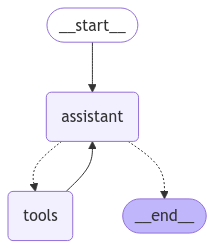

In [91]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", simple_assistant)
builder.add_node("tools", ToolNode(tools=[search_tool]))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [92]:
user_input = input("Enter your product: ")
product = user_input.strip()
# Create an initial message with user input, and wrap it in a list
initial_messages = [HumanMessage(content=f"What kind of product is {product}?")]
# Pass the initial messages to the state graph's `messages` key within the input dictionary
messages = react_graph.invoke({"messages": initial_messages})
for m in messages['messages']:
    m.pretty_print()

Enter your product: CMCN618B


> Entering new AgentExecutor chain...
 I should use DuckDuckGo Search to perform a web search.
Action: DuckDuckGo Search
Action Input: 'CMCN618B'
Observation: See more Craftsman CMCN618B V20 18-Gauge Brad Nailer To... Share. Picture 1 of 3. 11. Gallery. Picture 1 of 3. Have one to sell? Sell now. Craftsman 18 GA Brad Nailer V20 Cordless Model CMCN618B - TOOL ONLY (NEW) fl3-agfam (1025) 100% positive; Seller's other items Seller's other items; Contact seller; US $65.00. 1 bid. See more Craftsman CMCN618B V20 18-Gauge Brad Nailer To... Share. Picture 1 of 7. Gallery. Picture 1 of 7. Have one to sell? Sell now. CRAFTSMAN V20 Brad Nailer, 18GA, Cordless, Bare Tool Only (CMCN618B) usuzhenyidia (17) 100% positive; Seller's other items Seller's other items; Contact seller; US $120.65. The Craftsman Cordless Brad Nailer 20V, 18ga (Tool Only) Cmcn618b is a powerful and reliable cordless nailer designed for a variety of nailing tasks. With a 20V power source, this 

In [93]:
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [94]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
user_input = input("Enter your product: ")
product = user_input.strip()
messages = [HumanMessage(content=f"What kind of product is {product}?")]
# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

Enter your product: CMCN618B


> Entering new AgentExecutor chain...
 I should use DuckDuckGo Search to perform a web search.
Action: DuckDuckGo Search
Action Input: 'CMCN618B'
Observation: See more Craftsman CMCN618B V20 18-Gauge Brad Nailer To... Share. Picture 1 of 3. 11. Gallery. Picture 1 of 3. Have one to sell? Sell now. Craftsman 18 GA Brad Nailer V20 Cordless Model CMCN618B - TOOL ONLY (NEW) fl3-agfam (1025) 100% positive; Seller's other items Seller's other items; Contact seller; US $65.00. 1 bid. See more Craftsman CMCN618B V20 18-Gauge Brad Nailer To... Share. Picture 1 of 7. Gallery. Picture 1 of 7. Have one to sell? Sell now. CRAFTSMAN V20 Brad Nailer, 18GA, Cordless, Bare Tool Only (CMCN618B) usuzhenyidia (17) 100% positive; Seller's other items Seller's other items; Contact seller; US $120.65. The Craftsman Cordless Brad Nailer 20V, 18ga (Tool Only) Cmcn618b is a powerful and reliable cordless nailer designed for a variety of nailing tasks. With a 20V power source, this 

In [95]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

while True:
    # Get user input
    user_input = input("Enter your product (or type 'bye'/'quit' to exit): ").strip()

    # Check exit condition
    if user_input.lower() in ["bye", "quit"]:
        print("Goodbye! Exiting the program.")
        break

    # Process input
    product = user_input.strip()
    messages = [HumanMessage(content=f"What kind of product is {product}?")]

    # Run the model
    messages = react_graph_memory.invoke({"messages": messages}, config)

    # Print responses
    for m in messages['messages']:
        m.pretty_print()
    product = ''

Enter your product (or type 'bye'/'quit' to exit): CMCN618B


> Entering new AgentExecutor chain...
 I should use DuckDuckGo Search to find information about the Craftsman Cordless Brad Nailer 20V, 18ga (Tool Only) Cmcn618b
Action: DuckDuckGo Search
Action Input: 'Craftsman Cordless Brad Nailer 20V, 18ga (Tool Only) Cmcn618b'
Observation: Milwaukee M12 12V 23 Gauge Cordless Pin Nailer Tool (2540-20) DEWALT 20V MAX XR 18-Gauge Brad Nailer (Tool Only) - DCN680B Arrow Heavy Duty Professional Hammer and Tacker Tool - HT50P See more Craftsman CMCN618B V20 18-Gauge Brad Nailer To... Share. Picture 1 of 7. Gallery. ... DEWALT 20V MAX XR 18-Gauge Brad Nailer (Tool Only) - DCN680B; Arrow Heavy Duty Professional Hammer and Tacker Tool - HT50P ... Craftsman Cordless Nailer; Craftsman 16 Gauge Finish Nailer Cordless; Craftsman Electric Nailer; Dewalt 18 Gauge Brad Nailer ... Set Alert for Craftsman CMCN618 Cordless 20 Volt 18-Gauge Brad Nailer Tool Only - $89.00. Your Email. Desired Price $ ... Cr

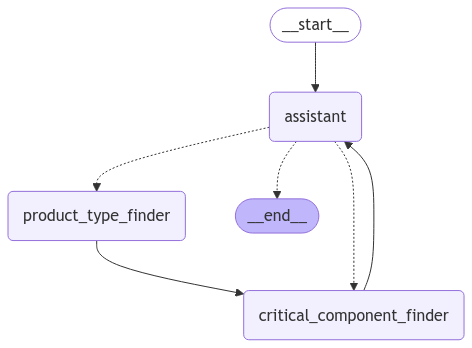

In [96]:
# Define ToolNode functions
def product_type_finder_agent(messages):
    """Finds product type for the given input"""
    product = messages[-1].content.strip()

    if not product or product.lower() in ["bye", "quit"]:
        return {"messages": [HumanMessage(content="Exiting the program.")], "end": True}

    return {"messages": [HumanMessage(content=f"The product '{product}' is a type of [Product Category].")]}

def critical_component_finder_agent(messages):
    """Finds critical components for the product type"""
    product_type = messages[-1].content.strip()

    return {"messages": [HumanMessage(content=f"Critical components for {product_type} include: [Component List].")]}

# Create ToolNodes
product_type_tool = ToolNode([Tool(name="product_type_finder", func=product_type_finder_agent, description="Finds product type")])
critical_component_tool = ToolNode([Tool(name="critical_component_finder", func=critical_component_finder_agent, description="Finds critical components of a type of product")])

# Define Assistant Node
def assistant(messages):
    """Processes user input and determines next steps"""
    user_input = messages[-1].content.strip().lower()

    if user_input in ["bye", "quit"]:
        return {"messages": [HumanMessage(content="Goodbye! Exiting.")], "end": True}

    return {"messages": [HumanMessage(content=f"Processing request for '{user_input}'...")], "next": "product_type_finder"}

# Graph Definition
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("product_type_finder", product_type_tool)
builder.add_node("critical_component_finder", critical_component_tool)

# Define edges for control flow
builder.add_edge(START, "assistant")  # Start with Assistant
builder.add_conditional_edges(
    "assistant",
    lambda state: "product_type_finder" if state.messages[-1].content.strip().lower() not in ["bye", "quit"] else END
)
#builder.add_edge("assistant", "product_type_finder")  # Assistant calls Product Type Finder
builder.add_edge("product_type_finder", "critical_component_finder")  # Product Type Finder calls Critical Component Finder
builder.add_edge("critical_component_finder", "assistant")  # Control returns to Assistant

# Compile the graph
react_graph = builder.compile()

# Display graph visualization
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

while True:
    # Get user input
    user_input = input("Enter your product (or type 'bye'/'quit'/'exit'/'q' to exit): ").strip()

    # Check exit condition before running the agent
    if user_input.lower() in ["bye", "quit", "exit", "q"]:
        print("Goodbye! Exiting the program.")
        break

    # Create a message list with user input
    messages = [HumanMessage(content=f"What kind of product is {user_input}?")]

    # Run the ReAct agent
    response = react_graph_memory.invoke({"messages": messages}, config)

    # Print responses
    if "messages" in response:
        for m in response["messages"]:
            print(m.content.strip())  # Print clean response
    else:
        print("Error: No response from ReAct agent.")


Enter your product (or type 'bye'/'quit'/'exit'/'q' to exit): CMCN618B


> Entering new AgentExecutor chain...
 I should use DuckDuckGo Search to find information about the product CMCN618B
Action: DuckDuckGo Search
Action Input: CMCN618B
Observation: The V20 18 Ga. Cordless Brad Nailer is a game-changer for anyone in need of a powerful and convenient nail gun. This cordless nailer eliminates the need for compressors, hoses, and gas cartridges, making it incredibly convenient and easy to use. With a powerful motor that can drive up to 420 nails per charge, this […] The V20 18 Ga. The tool-free depth setting allows you to adjust the nail depth quickly. Convenience: belt hook for easy access. Optimal balance: lightweight with optimal center of gravity providing balance and comfort during use. Model: CRAFTSMAN V20 Brad Nailer, 18GA, Cordless, Bare Tool Only (CMCN618B) Deal History Deal History includes data from multiple reputable stores, such as Best Buy, Target, and Walmart. The lowest 